In [39]:
#%run InsertsDelComparisons.ipynb

In [40]:
import import_ipynb
from InsertsDelComparisons import sorted_users, np, df, INDICES, KEYWORDS, \
    map_, pd, indices_of_first_attempts_per_user, \
        get_data_per_session, plot_users_sessions, bubble_plot_recipe, data_computation_on_groups, plot_group_at_recipe
import ast
from DataFormatting import recipes_indices

In [41]:
import os
import pm4py
from pm4py.visualization.petri_net import  visualizer as pn_vis_factory
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.alpha import  algorithm as alpha_miner

def save_user_session_info_graph(csv_filepath, group_num):
    graph_data = csv_filepath
    dataframe = pd.read_csv(graph_data, sep=';')
    event_log = pm4py.format_dataframe(dataframe, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
    event_log = pm4py.convert_to_event_log(dataframe)

    new_file = 'xes_format.xes'
    pm4py.write_xes(event_log, new_file)
    log = pm4py.read_xes(new_file)
    net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
    performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(event_log)
    
    try:
        pm4py.save_vis_performance_dfg(performance_dfg, start_activities, end_activities, 'results/process mining/groupnum{n}.png'.format(n=group_num))
    except: print('user only has 1 recipe')

#pn_vis_factory(pn_vis_factory.apply(net, initial_marking, final_marking))

In [42]:
ACTIONS = [';1st recipe submitted;', ';revision;', ';second recipe submitted;']
def format_user_data(user_index, with_enumeration=False, case_id=1):
    recipe_indices = map_[user_index].copy()
    if user_index == 186: last_index_where_written = 1091
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)

    where_in_df = np.where(df['user_id'] == sorted_users[user_index])
    first_line = str(case_id) + ACTIONS[0] + df.iloc[where_in_df[0][0]]['event_date']

    lines = [first_line]

    for i, index in enumerate(range(recipe_indices[0]+1, recipe_indices[-1]+1)):
        j = index
        is_new_recipe = index in recipe_indices
        while not is_new_recipe:
            line = ACTIONS[1] + df.iloc[where_in_df[0][i+1]]['event_date']
            lines.append(line)
            j+=1
            if j in recipe_indices: is_new_recipe = True

        try:
            if index in recipe_indices : lines.append(ACTIONS[2] + df.iloc[where_in_df[0][i+1]]['event_date'])
        except: continue
        
    result = lines
    index = 1
    for i, line in enumerate(lines):
        j = index if with_enumeration else 1
       
        if line.startswith(ACTIONS[1]):
            result[i] = str(case_id) + line
        elif line.startswith(ACTIONS[2]):
            index+=1
            j = index if with_enumeration else 1
            second_recipe_already_submitted = False
            for l in lines[:i]:
                if ACTIONS[2] in l : second_recipe_already_submitted = True
            if second_recipe_already_submitted:
                result[i] = str(case_id) + line.replace('second', 'third')
            else : result[i] = str(case_id) + line

    return  pd.DataFrame(sorted(set(result), key=result.index), columns=['case_id;activity;timestamp'])

In [43]:
for i in range(0,5):
    dframes = []
    for j, user in enumerate(INDICES[i]):
        A = format_user_data(user_index=user, case_id=j+1)
        dframes.append(A)

    res = pd.concat(dframes)
    path = 'data/processMiningData/group{i}.csv'.format(i=i+1)
    res.to_csv(path, index=False)
    save_user_session_info_graph(csv_filepath=path, group_num=i+1)


parsing log, completed traces :: 100%|██████████| 40/40 [00:00<00:00, 4126.42it/s]


[[8, 31, 35, 41, 50, 56, 61, 69, 74, 85, 93, 100, 104, 128, 134, 182], [2, 5, 10, 14, 20, 44, 46, 55, 59, 60, 63, 84, 86, 90, 106, 107, 130, 170], [40, 51, 52, 82, 89, 91, 94, 113, 125, 161, 176, 179], [11, 13, 18, 30, 45, 57, 112, 114, 121, 147, 153, 156, 157], [0, 17, 19, 27, 32, 71, 108, 119, 122, 127, 146, 154, 158, 183]]
5e3b3479d0a20f34da37e342


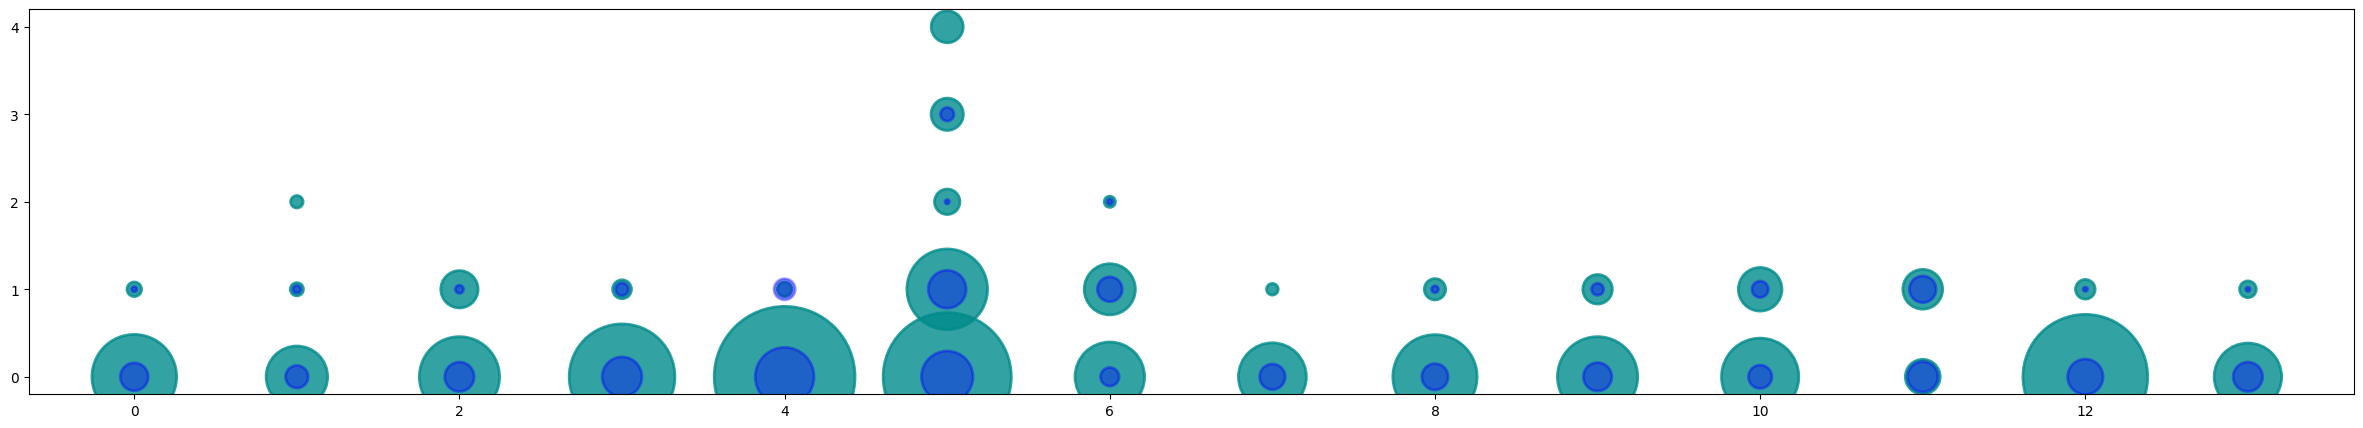

In [46]:
with_at_least_one_revision = []
for group in range(0,5):
    not_outliers = []
    for user_index in INDICES[group]:
        sessions = get_data_per_session(user_index)
        is_outlier = False
        for session in sessions:
            if len(session) < 2:
                is_outlier = True
        if not is_outlier:
            not_outliers.append(user_index)
    with_at_least_one_revision.append(not_outliers)

print(with_at_least_one_revision)

max_revisions, means, variances, avr_rev_lengths= data_computation_on_groups(0, with_at_least_one_revision)
group_characteristics = ["With Adaptive Feedback\nWith Reflective Prompts", "With Adaptive Feedback\nWithout Reflective Prompts", 
"Without Adaptive Feedback\nWith Reflective Prompts", "Without Adaptive Feedback\nWithout Reflective Prompts", "Control Group\nNo Adaptive Feedback\nNo Reflective Prompts"]
for group in range(1,6):
    text = \
    """
    Maximum number of revisions: {max}
    {mean}
    {var}
    {revision_length_mean}
    """.format(max=max_revisions[group-1], 
    mean=r'$\mu_{revisions}=%.3f$' % (means[group-1]), 
    var=r'$\sigma^2_{revisions}=%.3f$' % (variances[group-1]),
    revision_length_mean=r'$\mu_{revision lengths}=%.3f$' % (avr_rev_lengths[group-1])
    )